In [1]:
# !pip install -r requirements.txt

import warnings
import pandas as pd
from utils.LabelsDict import tickers

import logging
# Completely silence cmdstanpy and fbprophet
logging.getLogger('cmdstanpy').addHandler(logging.NullHandler())
logging.getLogger('cmdstanpy').propagate = False
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)

warnings.filterwarnings("ignore", category=UserWarning, message="Unable to import Axes3D")
warnings.filterwarnings("ignore", category=UserWarning, message="Workbook contains no default style")
warnings.filterwarnings("ignore", category=UserWarning, message="YF.download() has changed argument auto_adjust default to True")
warnings.filterwarnings("ignore", message="IProgress not found")

from utils.portfolio import Portfolio
from utils.logger import Logger
log = Logger(__name__)

In [2]:
# No Logger class to reset; handlers are cleared above if needed

# Define tickers list
tickers_list = [
    'GAZP', 'LKOH', 'ROSN',
    'SBER', 'VTBR', 'MOEX',
    'GMKN', 'NLMK', 'RUAL',
    'MTSS', 'RTKM', 'TTLK',
    'MGNT', 'FESH',  #LENT
]

# Recreate the Portfolio instance with the updated code
calc = Portfolio(
    dt_calc='2025-09-30',
    dt_start='2020-03-31',
    stocks_step=8,
    tickers_list=tickers_list
)
calc = calc.log_system_info()

2026-01-09 16:19:03,995:utils.portfolio:INFO: Configuration Parameters
Parameter                                                                                      Value
Calculation Date                                                                          2025-09-30
Start Date                                                                                2020-03-31
Stocks Step                                                                                        8
Tickers Count                                                                                     14
Tickers           GAZP, LKOH, ROSN, SBER, VTBR, MOEX, GMKN, NLMK, RUAL, MTSS, RTKM, TTLK, MGNT, FESH


In [3]:
# 2. Загрузка рыночных данных
calc = (
    calc
    .load_stock_data(
        use_backup_data=True,
        update_backup=False
    )
    .load_multipliers(
        use_backup=True,
        update_backup=False
    )
)

2026-01-09 16:19:07,260:utils.portfolio:INFO: Using stocks backup data from 2020-03-31 up to 2025-09-30
2026-01-09 16:19:07,341:utils.portfolio:INFO: Loaded Stock Data Period
Start Date    End Date
2020-03-31  2025-09-30
2026-01-09 16:19:07,347:utils.portfolio:INFO: Stock Data Missing Values: No missing values found
2026-01-09 16:19:07,354:utils.portfolio:INFO: Using multipliers backup data from 2020-03-31 up to 2025-09-30
2026-01-09 16:19:07,356:utils.portfolio:INFO: Loaded Multipliers Data Period
Start Date    End Date
2020-03-31  2025-09-30
2026-01-09 16:19:07,359:utils.portfolio:INFO: Multipliers Data Missing Values
Column                    Value
EV/EBITDA                30.12%
P/BV                     41.93%
P/E                      14.29%
P/FCF                    38.51%
P/S                      27.02%
Долг, млрд руб           46.58%
Долг/EBITDA              30.12%
Капитализация, млрд руб  13.04%
Чистый долг, млрд руб    13.04%


In [4]:
calc = (
    calc
    .load_macro_data(
        update_inflation=False,
        update_rub_usd=False,
        update_unemployment=False
    )
    .create_portfolio()
    .add_dynamic_features()
    .add_merton_pd()
)

2026-01-09 16:19:09,489:utils.portfolio:INFO: Loaded Unemployment data from backup
2026-01-09 16:19:09,497:utils.portfolio:INFO: Loaded Unemployment Data Period
Start Date    End Date
2020-03-31  2025-09-30
2026-01-09 16:19:09,519:utils.portfolio:INFO: Loaded inflation data from backup
2026-01-09 16:19:09,526:utils.portfolio:INFO: Loaded Inflation Data Period
Start Date    End Date
2020-03-31  2025-09-30
2026-01-09 16:19:09,535:utils.portfolio:INFO: Loaded USD/RUB exchange rate from backup
2026-01-09 16:19:09,546:utils.portfolio:INFO: Loaded USD/RUB Exchange Rate Period
Start Date    End Date
2020-03-31  2025-09-30
2026-01-09 16:19:09,698:utils.portfolio:INFO: Portfolio Missing Values Before Filling
Column                    Value
P/E                      14.30%
Долг, млрд руб           46.56%
Капитализация, млрд руб  13.01%
Чистый долг, млрд руб    13.01%
debt                     33.63%
2026-01-09 16:19:09,755:utils.portfolio:INFO: Portfolio Missing Values After Filling
Column        

Solving Merton equations: 100%|██████████| 19841/19841 [00:55<00:00, 356.81it/s]

2026-01-09 16:20:05,417:utils.portfolio:INFO: Capital cost and capital volatility calculated.
2026-01-09 16:20:05,422:utils.portfolio:INFO: Merton's probabilities of default calculated.


In [6]:
#calc.plot_pd_by_tickers(tickers=tickers_list, verbose=True, figsize=(12, 5))
#calc.plot_stocks(tickers=tickers_list, verbose=True, figsize=(12, 5))         # нарисовать динамику котировок акций
#calc.plot_debt_capitalization(verbose=True, figsize=(12, 5))                  # нарисовать динамику долга и стоимости активов
# calc.calc_irf(impulses_responses = {                          # расчитать функции импульсного отклика
#     'inflation': 'PD', 'interest_rate': 'PD',
#     'rubusd_exchange_rate': 'PD', 'unemployment_rate': 'PD'
# }, verbose=True)
# calc.plot_correlation_matrix(custom_order = [                 # нарисовать матрицу корреляций
#     'GAZP', 'LKOH', 'ROSN',                               # Нефтегазовая отрасль
#     'SBER', 'VTBR', 'MOEX',                               # Финансовый сектор
#     'GMKN', 'NLMK', 'RUAL',                               # Металлургия
#     'MTSS', 'RTKM', 'TTLK',                               # Телекоммуникации
#     'MGNT', 'LNTA', 'FESH'                                # Розничная торговля
# ], verbose=False)
# calc.calc_macro_connections()                                 # расчитать регрессию для макропараметров
# calc.log_completion()                                         # вывести в лог сообщение об окончании расчета



2026-01-09 16:20:44,043:utils.portfolio:INFO: Visualizing Expanding Window backtest for last 3 months


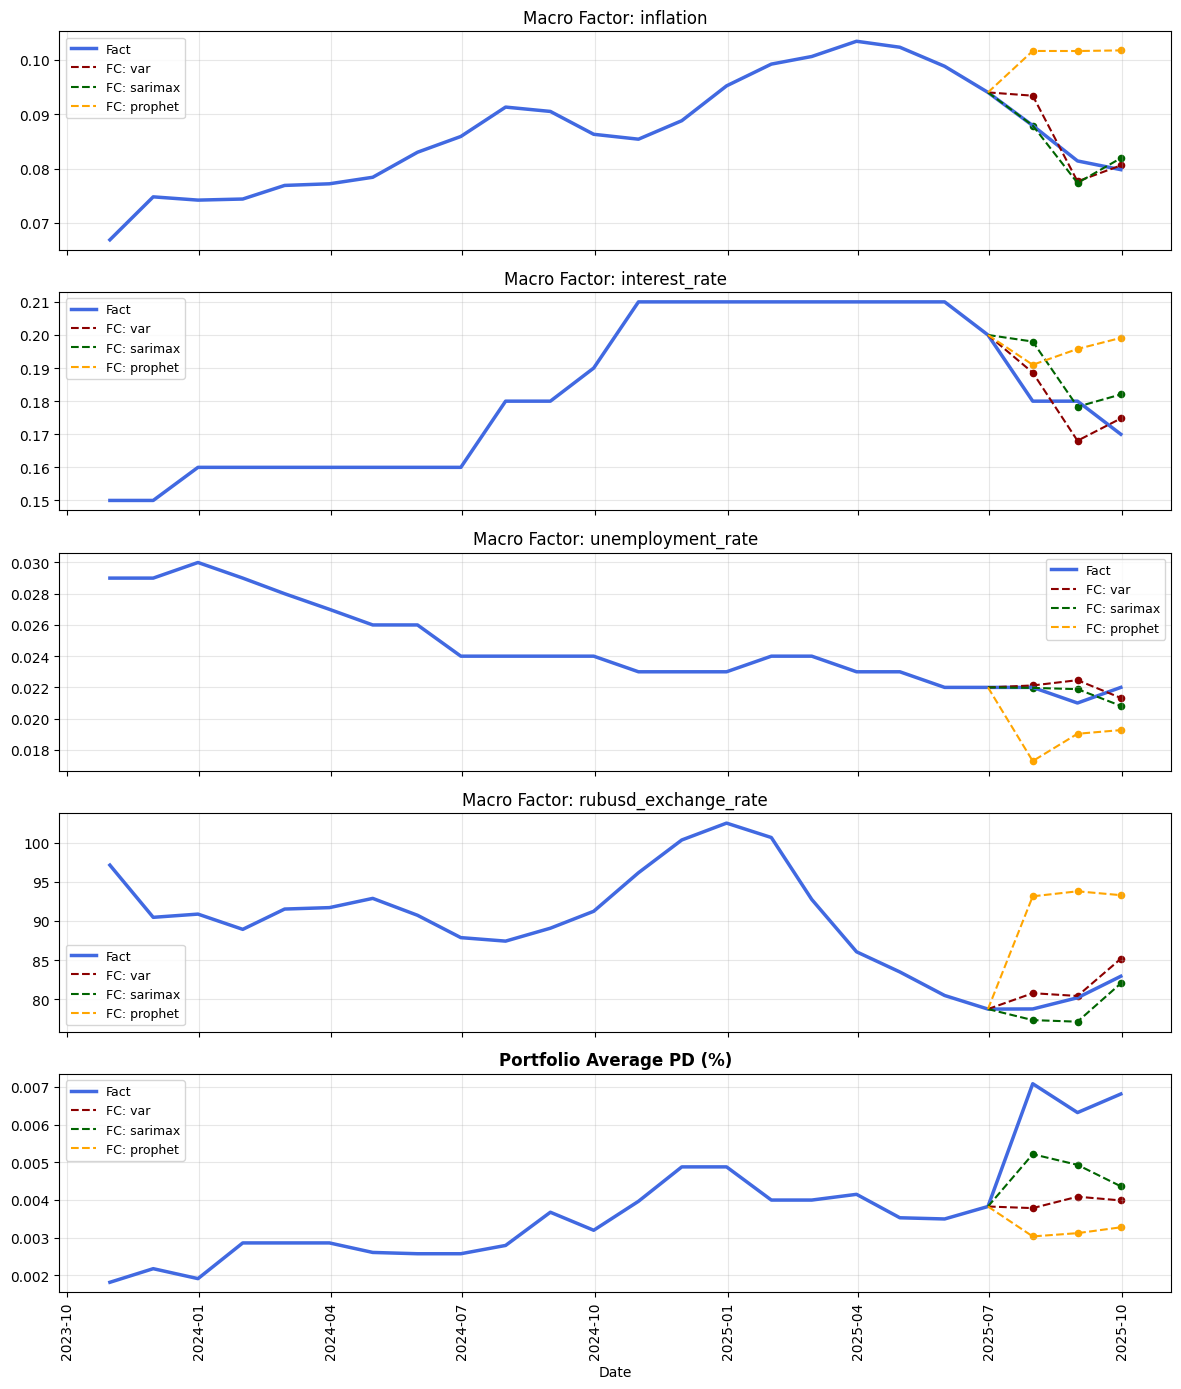

2026-01-09 16:21:11,006:utils.plots:INFO: Macro comparison plot saved: logs/graphs/macro_pd_comparison.png


In [ ]:
# Вы можете передать список моделей ['var', 'sarimax', 'prophet'] для сравнения
calc = calc.plot_macro_forecast(
    horizon=-3,
    models=['var', 'sarimax', 'prophet'],
    tail=24,
    verbose=True
)

In [ ]:
# 3. Бэктест прогноза PD для разных макромоделей
# Метод backtest_pd теперь принимает список моделей и сравнивает их точность
# на "расширяющемся окне" (expanding window) за указанный период (n_months)

calc.backtest_pd(
    n_months=6,
    models=['var', 'sarimax', 'prophet']
)

# Вывод первых строк результатов бэктеста PD
display(calc.d['pd_backtest'].head(10))

# Теперь можно сравнить среднюю ошибку (MAE) для каждой модели
backtest_res = calc.d['pd_backtest']
backtest_res['abs_error'] = (backtest_res['predicted_pd'] - backtest_res['reference_pd']).abs()
mae_comparison = backtest_res.groupby('model')['abs_error'].mean().sort_values()

print("\nСредняя ошибка прогноза PD (MAE) по моделям:")
print(mae_comparison)

2026-01-09 16:14:30,419:utils.portfolio:INFO: Backtesting PD using var model...
2026-01-09 16:14:31,024:utils.portfolio:INFO: Backtesting PD using sarimax model...
2026-01-09 16:14:34,135:utils.portfolio:INFO: Backtesting PD using prophet model...


,ticker,predicted_pd,reference_pd,delta,model,date
0,FESH,0.000000e+00,3.692891e-07,-4.366194e-04,var,2025-04-30
1,GAZP,1.524854e-04,1.793016e-04,-2.681615e-05,var,2025-04-30
2,GMKN,7.478367e-09,1.625819e-08,-8.779819e-09,var,2025-04-30
3,LKOH,2.962742e-12,1.619505e-24,2.962742e-12,var,2025-04-30
4,MGNT,6.408143e-07,8.473990e-06,-7.833175e-06,var,2025-04-30
5,MOEX,1.260295e-10,2.119779e-13,1.258175e-10,var,2025-04-30
6,MTSS,4.999516e-07,5.616199e-07,-6.166827e-08,var,2025-04-30
7,NLMK,2.377083e-08,1.761130e-17,2.377083e-08,var,2025-04-30
8,ROSN,7.115531e-06,7.469766e-07,6.368555e-06,var,2025-04-30
9,RTKM,3.935664e-06,9.051481e-06,-5.115817e-06,var,2025-04-30



Средняя ошибка прогноза PD (MAE) по моделям:
model
var        0.000017
sarimax    0.000018
prophet    0.000020
Name: abs_error, dtype: float64


In [ ]:
# 4. Визуализация бэктеста: Макро-прогноз + Вероятность дефолта
# Теперь метод plot_macro_forecast автоматически рассчитывает и отображает
# среднюю вероятность дефолта (PD) по портфелю для каждой макро-модели.

calc.plot_macro_forecast(
    horizon=-6,                    # Бэктест на 6 месяцев назад
    models=['var', 'sarimax'],      # Сравнение моделей
    tail=24,                       # Показать историю за последние 24 месяца
    verbose=True,
    figsize=(12, 16)               # Увеличенная высота для дополнительного графика PD
)

2026-01-09 13:10:31,386:utils.plots:INFO: p-values before differencing:
PD                      0.000007
inflation               0.276800
interest_rate           0.624814
rubusd_exchange_rate    0.542667
unemployment_rate       0.916680
dtype: float64
2026-01-09 13:10:31,393:utils.plots:INFO: Applied differencing to achieve stationarity
2026-01-09 13:10:31,689:utils.plots:INFO: p-values after differencing:
PD                      0.000000e+00
inflation               0.000000e+00
interest_rate           3.014034e-11
rubusd_exchange_rate    1.109440e-24
unemployment_rate       0.000000e+00
dtype: float64
2026-01-09 13:10:31,725:utils.plots:INFO: Optimal lag number calculated | Optimal number of lags: 1


c:\Users\Maxim\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


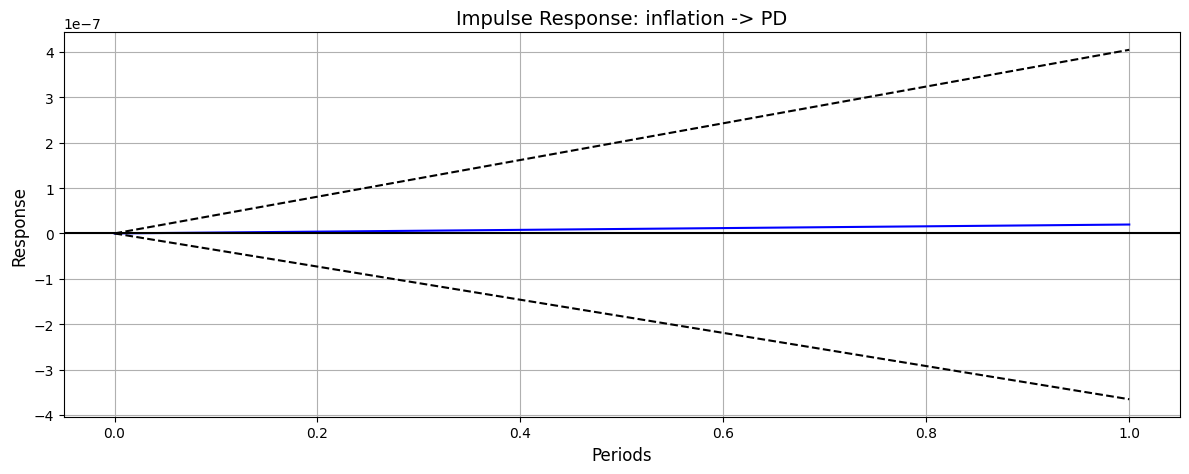

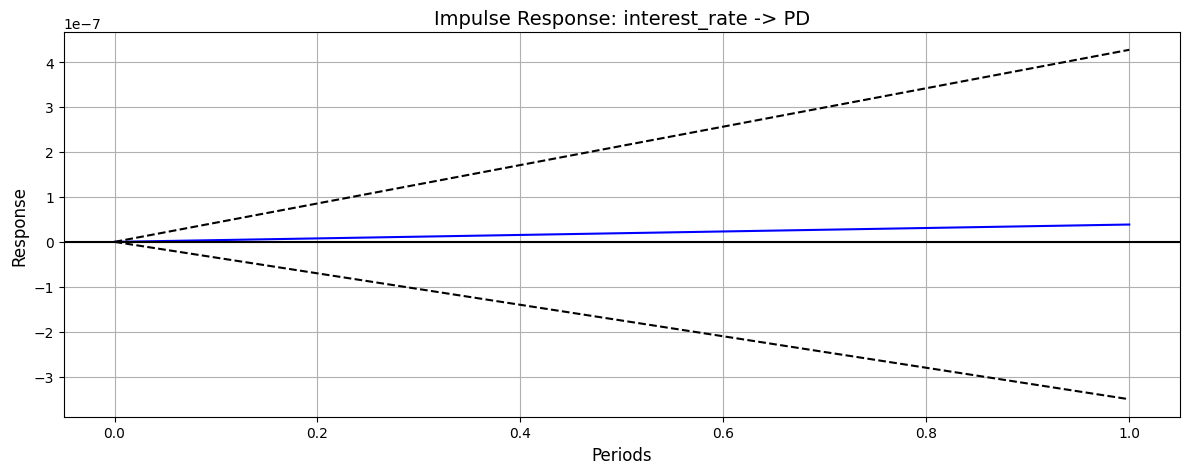

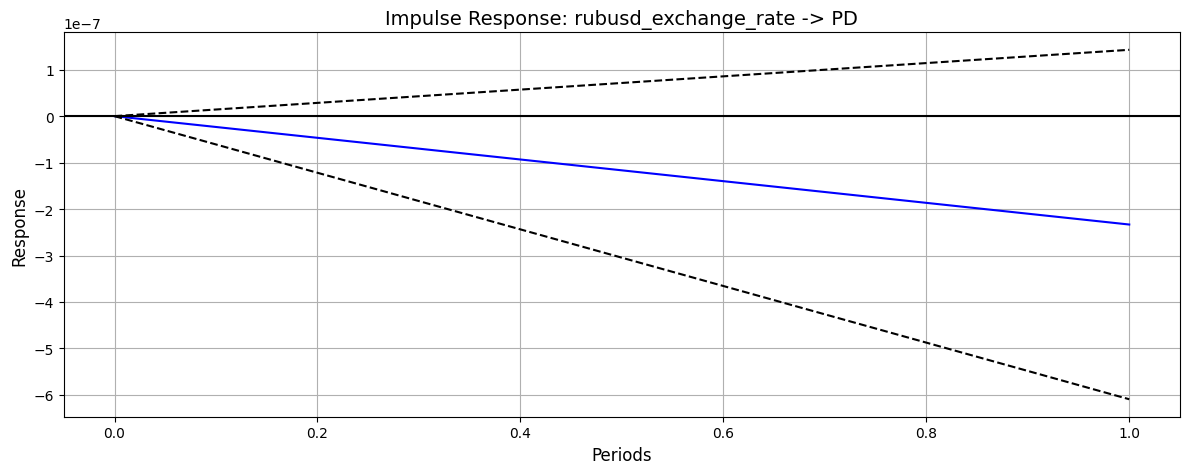

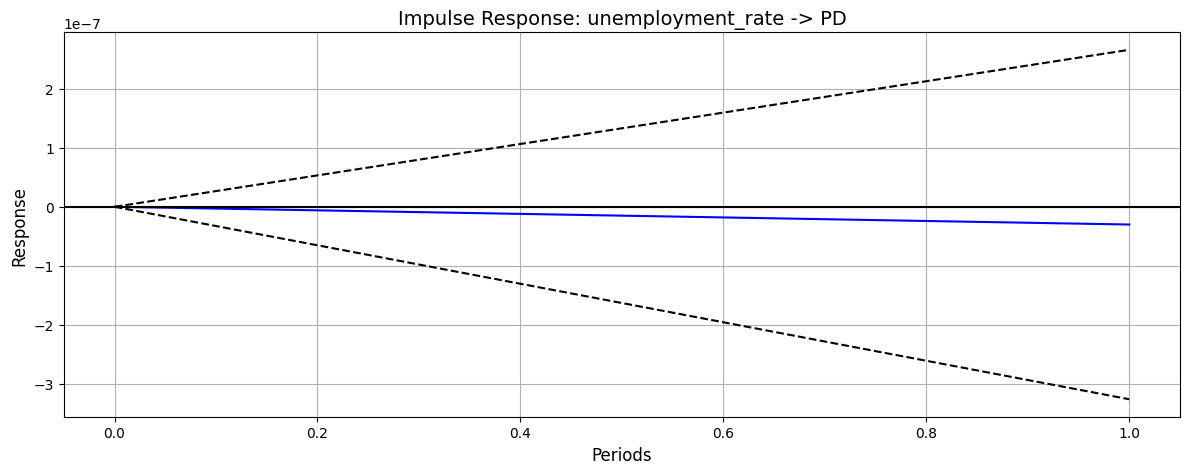

2026-01-09 13:10:32,539:utils.plots:INFO: Impulse response functions saved | Path: logs/graphs/
2026-01-09 13:10:33,736:utils.plots:INFO: Correlation matrix saved | Path: logs/graphs/corr_matrix.png


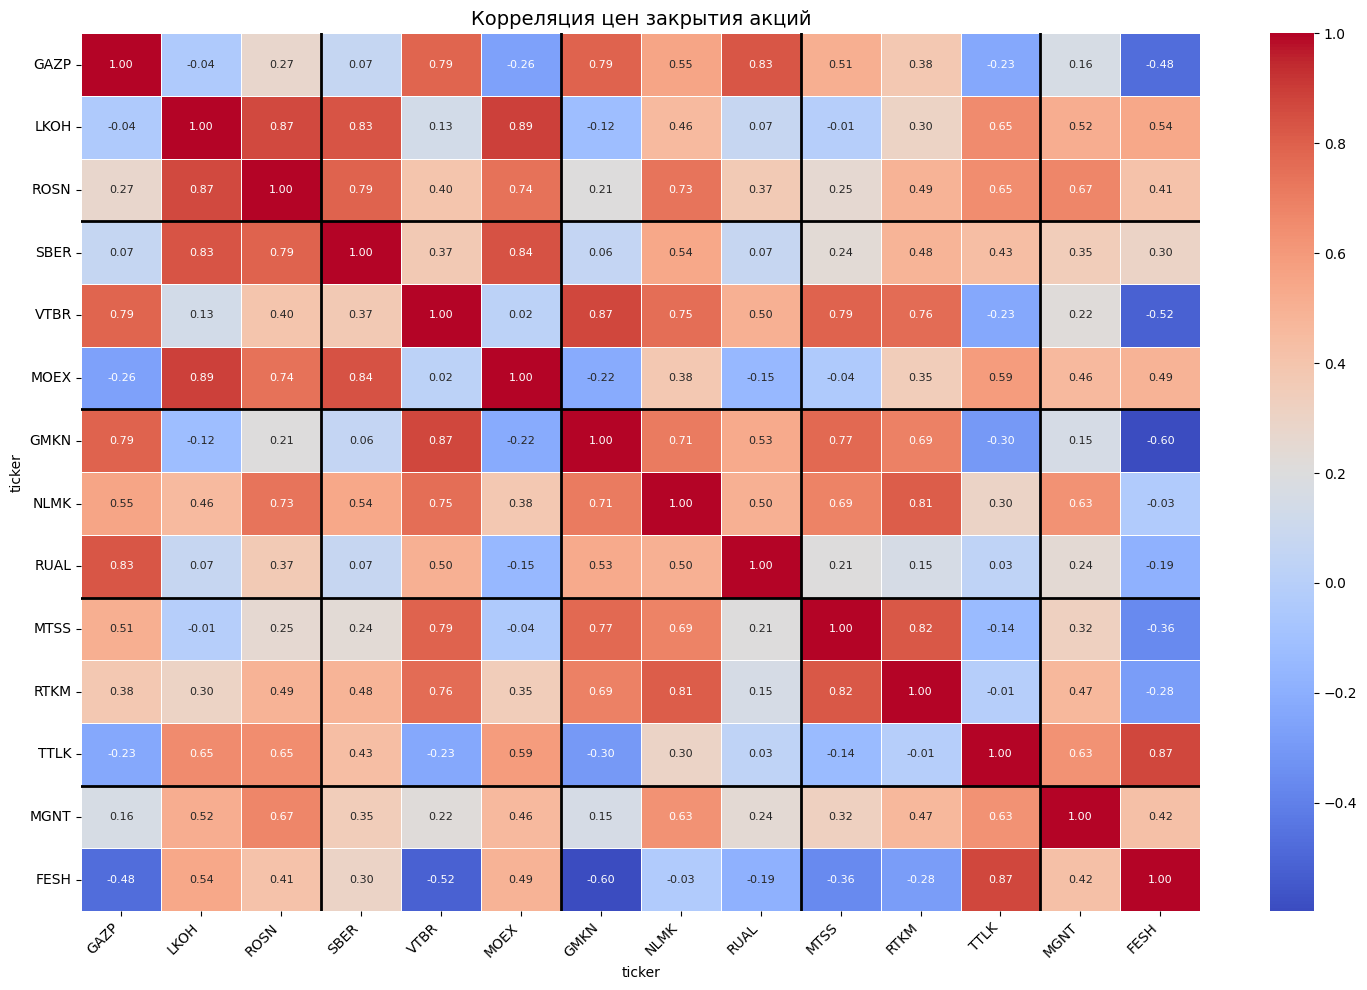

2026-01-09 13:11:07,755:utils.portfolio:INFO: Macro connection summary calculated.
2026-01-09 13:11:07,757:utils.portfolio:INFO: ============================================================
2026-01-09 13:11:07,757:utils.portfolio:INFO: ANALYSIS COMPLETED | Duration: 240.7 sec
2026-01-09 13:11:07,757:utils.portfolio:INFO: ============================================================


In [10]:
calc.calc_irf(impulses_responses = {                          # расчитать функции импульсного отклика
    'inflation': 'PD', 'interest_rate': 'PD',
    'rubusd_exchange_rate': 'PD', 'unemployment_rate': 'PD'
}, verbose=True)
calc.plot_correlation_matrix(custom_order = [                 # нарисовать матрицу корреляций
    'GAZP', 'LKOH', 'ROSN',                               # Нефтегазовая отрасль
    'SBER', 'VTBR', 'MOEX',                               # Финансовый сектор
    'GMKN', 'NLMK', 'RUAL',                               # Металлургия
    'MTSS', 'RTKM', 'TTLK',                               # Телекоммуникации
    'MGNT', 'LNTA', 'FESH'                                # Розничная торговля
], verbose=True)
calc.calc_macro_connections()                                 # расчитать регрессию для макропараметров
calc.log_completion()                                         # вывести в лог сообщение об окончании расчета